### INCLUDE MEAN TEACHER AND UNLABELLED

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, Sampler, DataLoader, Subset, SubsetRandomSampler, BatchSampler
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt 
from helper_functions_2 import softmax_kl_loss, sigmoid_rampup, get_current_consistency_weight, linear_rampup, grouper, relabel_dataset
import time

from math import sqrt

c:\Users\Parth\miniconda3\envs\tftorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

class_names = train_data.classes
class_names

NameError: name 'datasets' is not defined

In [42]:
NO_LABEL = -1
BATCH_SIZE = 16

class Arguments():
    def __init__(self, momentum, weight_decay, nesterov, epochs:int, consistency, exclude_unlabeled:bool, batch_size=64, labeled_batch_size=32, consistency_type='kl', lr=0.01, initial_lr=0.005, lr_rampup = 9, ema_decay=0.999, consistency_rampup=5, early_stop=0.5):
        super().__init__()

        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.nesterov = nesterov
        self.epochs = epochs
        self.consistency_type = consistency_type
        self.initial_lr = initial_lr
        self.lr_rampup = lr_rampup
        self.consistency = consistency
        self.ema_decay = ema_decay
        self.labeled_batch_size = labeled_batch_size
        self.exclude_unlabeled = exclude_unlabeled
        self.batch_size = batch_size
        self.consistency_rampup = consistency_rampup
        self.early_stop = early_stop

args = Arguments(lr=0.01, momentum=0.9, weight_decay=0, nesterov=False, epochs=30, exclude_unlabeled=False, consistency=100, batch_size=64, labeled_batch_size=24)

In [43]:
""" train_loader = torch.utils.data.DataLoader(
        dataset= train_data,
        batch_size=args.batch_size,
        shuffle=False,
        pin_memory=True,
        drop_last=False)

eval_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=args.batch_size,
    shuffle=False,
    pin_memory=True,
    drop_last=False) """

' train_loader = torch.utils.data.DataLoader(\n        dataset= train_data,\n        batch_size=args.batch_size,\n        shuffle=False,\n        pin_memory=True,\n        drop_last=False)\n\neval_loader = torch.utils.data.DataLoader(\n    dataset=test_data,\n    batch_size=args.batch_size,\n    shuffle=False,\n    pin_memory=True,\n    drop_last=False) '

In [44]:
""" class CustomTrainDataset(Dataset):

    def  __init__(self, train_data, labels=None):
        self.data = train_data
        self.labels = labels

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        img = img.numpy().astype(np.uint8).astype(np.uint8)
        label = self.labels[idx]

        return img, label """

' class CustomTrainDataset(Dataset):\n\n    def  __init__(self, train_data, labels=None):\n        self.data = train_data\n        self.labels = labels\n\n    def __len__(self):\n        return len(self.data)\n    \n    def __getitem__(self, idx):\n        img = self.data[idx]\n        img = img.numpy().astype(np.uint8).astype(np.uint8)\n        label = self.labels[idx]\n\n        return img, label '

In [45]:
""" train_dataset = CustomTrainDataset(train_data.data, train_data.targets)
train_loader = DataLoader(train_dataset, BATCH_SIZE, False)
X, y = next(iter(train_loader))
X, y = next(iter(train_loader))
N = int(sqrt(BATCH_SIZE))

fig, axs = plt.subplots(N, N, figsize=(15,15))
for i in range(len(y)):
    img = X[i]
    label = y[i]
    ax = fig.add_subplot(N, N, i+1)
    ax.imshow(img.reshape(28, 28),cmap="gray")
    ax.set_xticks([]) #set empty label for x axis
    ax.set_yticks([]) #set empty label for y axis
    ax.set_title(f"{class_names[label]}")

plt.show() """

' train_dataset = CustomTrainDataset(train_data.data, train_data.targets)\ntrain_loader = DataLoader(train_dataset, BATCH_SIZE, False)\nX, y = next(iter(train_loader))\nX, y = next(iter(train_loader))\nN = int(sqrt(BATCH_SIZE))\n\nfig, axs = plt.subplots(N, N, figsize=(15,15))\nfor i in range(len(y)):\n    img = X[i]\n    label = y[i]\n    ax = fig.add_subplot(N, N, i+1)\n    ax.imshow(img.reshape(28, 28),cmap="gray")\n    ax.set_xticks([]) #set empty label for x axis\n    ax.set_yticks([]) #set empty label for y axis\n    ax.set_title(f"{class_names[label]}")\n\nplt.show() '

In [46]:
split = 1 - args.labeled_batch_size/args.batch_size
NO_LABEL = -1
BATCH_SIZE = args.batch_size

""" # IS this the problem 
if(args.exclude_unlabeled == False):
    labelled_train_data, unlabelled_train_data, labels_train, unlabels_train = train_test_split(train_data.data, train_data.targets, stratify=train_data.targets, test_size=split)
else: # This is not the problem
    labelled_train_data = train_data.data
    labels_train = train_data.targets """


' # IS this the problem \nif(args.exclude_unlabeled == False):\n    labelled_train_data, unlabelled_train_data, labels_train, unlabels_train = train_test_split(train_data.data, train_data.targets, stratify=train_data.targets, test_size=split)\nelse: # This is not the problem\n    labelled_train_data = train_data.data\n    labels_train = train_data.targets '

In [47]:
split

0.625

In [48]:
# TEST CELL

train_set_size = int(len(train_data) * split)
valid_set_size = len(train_data) - train_set_size
labelled_data, unlabelled_data = torch.utils.data.random_split(train_data, [train_set_size, valid_set_size])

data_0 = []
labels_0 = []
data_1 = []

data_test = []
labels_test = []

for (X, y) in labelled_data:
    data_0.append(X)
    labels_0.append(y)

for (X, y) in test_data:
    data_test.append(X)
    labels_test.append(y)

for (X, y) in unlabelled_data:
    data_1.append(X)

In [49]:
type(labels_test[0])

int

In [50]:
class CustomTrainDataset(Dataset):
    def __init__(self, train_data, labels=None):
        self.base_data = train_data
        if(labels == None):
            self.labels = [-1 for i in range(len(self.base_data))]
        else:
            self.labels = labels
        super().__init__()

    def __len__(self):
        return len(self.base_data)

    def __getitem__(self, idx):
        img = self.base_data[idx]
        # img = img.unsqueeze(dim=0)
        label = self.labels[idx]
        return img, label

labelled_dataset = CustomTrainDataset(train_data=data_0, labels=labels_0)
if(args.exclude_unlabeled == False):
    unlabelled_dataset = CustomTrainDataset(train_data=data_1)
    train_dataset = torch.utils.data.ConcatDataset([labelled_dataset, unlabelled_dataset])
else:
    train_dataset = labelled_dataset

test_dataset = CustomTrainDataset(train_data=data_test, labels=labels_test)

In [51]:
""" # TEST CELL

labelled_train_data, unlabelled_train_data, labels_train, unlabels_train = train_test_split(train_data.data, train_data.targets, stratify=train_data.targets, test_size=0.2)
labelled_dataset = CustomTrainDataset(train_data=labelled_train_data, labels=labels_train)
unlabelled_dataset = CustomTrainDataset(train_data=unlabelled_train_data)
train_dataset = torch.utils.data.ConcatDataset([labelled_dataset, unlabelled_dataset]) """

' # TEST CELL\n\nlabelled_train_data, unlabelled_train_data, labels_train, unlabels_train = train_test_split(train_data.data, train_data.targets, stratify=train_data.targets, test_size=0.2)\nlabelled_dataset = CustomTrainDataset(train_data=labelled_train_data, labels=labels_train)\nunlabelled_dataset = CustomTrainDataset(train_data=unlabelled_train_data)\ntrain_dataset = torch.utils.data.ConcatDataset([labelled_dataset, unlabelled_dataset]) '

In [52]:
""" # TEST CELL

# train_loader = DataLoader(unlabelled_dataset, BATCH_SIZE, False)
X, y = next(iter(train_loader))
# X, y = next(iter(eval_loader))
N = int(sqrt(BATCH_SIZE))

fig, axs = plt.subplots(N, N, figsize=(17,17))
for i in range(len(y)):
    img = X[i]
    label = y[i]
    ax = fig.add_subplot(N, N, i+1)
    ax.imshow(img.reshape(28, 28),cmap="gray")
    ax.set_xticks([]) #set empty label for x axis
    ax.set_yticks([]) #set empty label for y axis
    if label != -1:
        title = f"{class_names[label]}"
    else:
        title = "NO_LABEL"
    ax.set_title(title)

plt.show() """

' # TEST CELL\n\n# train_loader = DataLoader(unlabelled_dataset, BATCH_SIZE, False)\nX, y = next(iter(train_loader))\n# X, y = next(iter(eval_loader))\nN = int(sqrt(BATCH_SIZE))\n\nfig, axs = plt.subplots(N, N, figsize=(17,17))\nfor i in range(len(y)):\n    img = X[i]\n    label = y[i]\n    ax = fig.add_subplot(N, N, i+1)\n    ax.imshow(img.reshape(28, 28),cmap="gray")\n    ax.set_xticks([]) #set empty label for x axis\n    ax.set_yticks([]) #set empty label for y axis\n    if label != -1:\n        title = f"{class_names[label]}"\n    else:\n        title = "NO_LABEL"\n    ax.set_title(title)\n\nplt.show() '

In [53]:
class TwoStreamBatchSampler(Sampler):
     
    def __init__(self, primary_indices, secondary_indices, batch_size, secondary_batch_size):
        self.primary_indices = primary_indices
        self.secondary_indices = secondary_indices
        self.secondary_batch_size = secondary_batch_size
        self.primary_batch_size = batch_size - secondary_batch_size

        assert len(self.primary_indices) >= self.primary_batch_size > 0
        assert len(self.secondary_indices) >= self.secondary_batch_size > 0
        
    def __iter__(self):
            primary_iter = np.random.permutation(self.primary_indices)
            secondary_iter = np.random.permutation(self.secondary_indices)
            return (
                primary_batch + secondary_batch
                for (primary_batch, secondary_batch)
                in  zip(grouper(primary_iter, self.primary_batch_size),
                        grouper(secondary_iter, self.secondary_batch_size)))

    def __len__(self):
        return len(self.primary_indices) // self.primary_batch_size


def create_data_loaders(train_dataset, test_dataset, args):
    
    labeled_idxs, unlabeled_idxs = relabel_dataset(dataset=train_dataset)

    print(f"labelled size: {len(labeled_idxs)}, unlabelled size: {len(unlabeled_idxs)}")

    if args.exclude_unlabeled:
        sampler = SubsetRandomSampler(labeled_idxs)
        batch_sampler = BatchSampler(sampler, args.batch_size, drop_last=True)
        
    else: 
        batch_sampler = TwoStreamBatchSampler(unlabeled_idxs, labeled_idxs, args.batch_size, args.labeled_batch_size)


    train_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_sampler=batch_sampler,
                                                pin_memory=True)

    eval_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        pin_memory=True,
        drop_last=False)
    
    return train_loader, eval_loader

train_loader, eval_loader = create_data_loaders(train_dataset, test_dataset, args)
    
# labelled_dataset = CustomTrainDataset(train_data=labelled_train_data, labels=labels_train)
# train_loader_custom = torch.utils.data.DataLoader(
#         dataset= labelled_dataset,
#         batch_size=args.batch_size,
#         shuffle=False,
#         pin_memory=True,
#         drop_last=False) 


labelled size: 37500, unlabelled size: 22500


In [54]:
""" # TEST CELL

train_loader = torch.utils.data.DataLoader(
        dataset= train_data,
        batch_size=args.batch_size,
        shuffle=False,
        pin_memory=True,
        drop_last=False)

eval_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=args.batch_size,
    shuffle=False,
    pin_memory=True,
    drop_last=False)

 """

' # TEST CELL\n\ntrain_loader = torch.utils.data.DataLoader(\n        dataset= train_data,\n        batch_size=args.batch_size,\n        shuffle=False,\n        pin_memory=True,\n        drop_last=False)\n\neval_loader = torch.utils.data.DataLoader(\n    dataset=test_data,\n    batch_size=args.batch_size,\n    shuffle=False,\n    pin_memory=True,\n    drop_last=False)\n\n '

In [62]:
class FashionMNSITModel_V2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)

        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        # x = self.conv_block_3(x)
        x = self.classifier(x)
        return x
    
torch.manual_seed(42)

model_2 = FashionMNSITModel_V2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
)

def create_models(input_shape: int, hidden_units: int, output_shape:int, ema=False):

    model = FashionMNSITModel_V2(
    input_shape=input_shape,
    hidden_units=hidden_units,
    output_shape=output_shape)

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

In [66]:
model_student = create_models(input_shape=1, hidden_units=15, output_shape=len(class_names))
model_teacher = create_models(input_shape=1, hidden_units=15, output_shape=len(class_names), ema=True)

optimizer = torch.optim.SGD(model_student.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay,
                                nesterov=args.nesterov)
optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [67]:

def adjust_learning_rate(optimizer, epoch, batch_num, batches_in_epoch, args):
    lr = args.lr
    epoch = epoch + batch_num / batches_in_epoch

    lr = linear_rampup(epoch, args.lr_rampup) * (args.lr - args.initial_lr) + args.initial_lr

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [68]:
def train(train_loader, model_student, model_teacher, optimizer, epoch, args):
    global global_step

    train_loss = 0

    # Is this the problem? maybe. consistency = 0. so we dont know
    class_criterion = nn.CrossEntropyLoss(reduction="sum",ignore_index=NO_LABEL)
    if args.consistency_type == 'kl':
         consistency_criterion = softmax_kl_loss

    model_student.train()
    model_teacher.train() # is this the problem - No

    start = time.time()

    for batch, (X, y) in enumerate(train_loader):

        # Adjust learning rate for minibatach - read more on this and minibatch/batch training
        # Is this the problem? maybe. consistency = 0. so we dont know
        if(args.exclude_unlabeled == False):
            adjust_learning_rate(optimizer, epoch, batch, len(train_loader), args)

        # Add noise to student and teacher inputs: ideally data should be augmented in the data loader. look more into it
        student_input_var = X + 0.01*torch.randn(size=X.shape) # Not the problem
        #student_input_var = student_input_var.unsqueeze(dim=1)
        teacher_input_var = X + 0.01*torch.randn(size=X.shape) # Not the problem
        #teacher_input_var = teacher_input_var.unsqueeze(dim=1)


        minibatch_size = len(y)

        # Forward Pass
        student_out = model_student(student_input_var)
        teacher_out = model_teacher(teacher_input_var) # is this the problem - No
        
        teacher_logit = teacher_out.detach().data # is this the problem - No

        ## Evaluate the Loss
        classification_loss = class_criterion(student_out, y) / minibatch_size
        teacher_classification_loss = class_criterion(teacher_logit, y) / minibatch_size # is this the problem - No
        
        # is this the problem - No (but consistency right now is 0, we will get back to it)
        if args.consistency:
            consistency_weight = get_current_consistency_weight(epoch, args)
            consistency_loss = consistency_weight * consistency_criterion(student_out, teacher_logit) / minibatch_size # is this the problem - No
        else:
            consistency_loss = 0

        loss = classification_loss + consistency_loss # is this the problem - No
        train_loss += loss

        ## The usual
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1
        
        update_ema_variables(model_student, model_teacher, args.ema_decay, global_step) # is this the problem

        end = time.time()

        num = int(len(train_loader)/2)
        if batch % num == 0:
            print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples")

    train_loss /= len(train_loader)

    print(f"Training Loss = {loss}, Consistency weight = {consistency_weight}")

    return train_loss, consistency_weight



In [69]:
def validate(eval_loader, model, args):

    test_acc = 0
    class_loss = 0
    class_criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=NO_LABEL)
    model.eval()

    with torch.inference_mode():
        for i, (input, target) in enumerate(eval_loader):

            minibatch_size = len(target)
            output = model(input)
            softmax1 = F.softmax(output, dim=1)
            class_loss += class_criterion(output, target) / minibatch_size

            test_acc += accuracy_fn(output, target, args)
        
        test_acc /= len(eval_loader)
        class_loss /= len(eval_loader)
        
    return test_acc, class_loss
        

In [70]:
from tqdm.auto import tqdm

student_accuracy = []
teacher_accuracy = []

s_loss_array = []
t_loss_array = []
train_loss_array = []
consistency_array = []

global_step = 0
for epoch in tqdm(range(args.epochs)):
    loss, weight = train(train_loader, model_student, model_teacher, optimizer, epoch, args)
    s_acc, s_loss = validate(eval_loader, model_student, args)
    student_accuracy.append(s_acc*100)
    t_acc, t_loss = validate(eval_loader, model_teacher, args)

    teacher_accuracy.append(t_acc*100)
    train_loss_array.append(loss)
    consistency_array.append(weight)
    s_loss_array.append(s_loss)
    t_loss_array.append(t_loss)

    
    print(f"Student Accuracy = {s_acc*100}, Teacher accuracy = {t_acc*100}")

    if(epoch>args.epochs/2):
        if student_accuracy[epoch] - student_accuracy[epoch-1] < args.early_stop:
            print("EARLY STOPPING")
            break

  0%|          | 0/30 [00:00<?, ?it/s]

Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7041842937469482, Consistency weight = 1.01069204986282


  3%|▎         | 1/30 [00:26<12:35, 26.04s/it]

Student Accuracy = 65.18710191082803, Teacher accuracy = 31.021098726114648
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7802753448486328, Consistency weight = 6.1143305967549315


  7%|▋         | 2/30 [00:52<12:16, 26.31s/it]

Student Accuracy = 73.90525477707006, Teacher accuracy = 62.44028662420382
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7996703386306763, Consistency weight = 24.794833233237984


 10%|█         | 3/30 [01:19<11:53, 26.43s/it]

Student Accuracy = 73.66640127388536, Teacher accuracy = 68.50119426751591
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7884341478347778, Consistency weight = 67.39934461758324


 13%|█▎        | 4/30 [01:45<11:23, 26.28s/it]

Student Accuracy = 72.70103503184714, Teacher accuracy = 70.5812101910828
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.8019489645957947, Consistency weight = 122.80961296169728


 17%|█▋        | 5/30 [02:11<10:55, 26.21s/it]

Student Accuracy = 72.81050955414013, Teacher accuracy = 71.45700636942675
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7962450981140137, Consistency weight = 150.0


 20%|██        | 6/30 [02:37<10:29, 26.22s/it]

Student Accuracy = 73.23845541401273, Teacher accuracy = 72.08399681528662
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7908448576927185, Consistency weight = 150.0


 23%|██▎       | 7/30 [03:03<10:04, 26.28s/it]

Student Accuracy = 73.66640127388536, Teacher accuracy = 72.76074840764332
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.8033903241157532, Consistency weight = 150.0


 27%|██▋       | 8/30 [03:30<09:39, 26.36s/it]

Student Accuracy = 75.0, Teacher accuracy = 73.45740445859873
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7942651510238647, Consistency weight = 150.0


 30%|███       | 9/30 [03:57<09:15, 26.45s/it]

Student Accuracy = 74.77109872611464, Teacher accuracy = 74.10429936305732
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7854158878326416, Consistency weight = 150.0


 33%|███▎      | 10/30 [04:23<08:50, 26.54s/it]

Student Accuracy = 76.04498407643312, Teacher accuracy = 74.72133757961782
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7984279990196228, Consistency weight = 150.0


 37%|███▋      | 11/30 [04:50<08:26, 26.67s/it]

Student Accuracy = 76.22412420382165, Teacher accuracy = 75.218949044586
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7805840969085693, Consistency weight = 150.0


 40%|████      | 12/30 [05:17<08:00, 26.69s/it]

Student Accuracy = 76.33359872611464, Teacher accuracy = 75.80613057324841
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7826857566833496, Consistency weight = 150.0


 43%|████▎     | 13/30 [05:44<07:34, 26.72s/it]

Student Accuracy = 77.14968152866241, Teacher accuracy = 76.21417197452229
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7738237977027893, Consistency weight = 150.0


 47%|████▋     | 14/30 [06:12<07:13, 27.06s/it]

Student Accuracy = 77.69705414012739, Teacher accuracy = 76.75159235668791
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7796899080276489, Consistency weight = 150.0


 50%|█████     | 15/30 [06:39<06:47, 27.14s/it]

Student Accuracy = 77.71695859872611, Teacher accuracy = 77.20939490445859
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7732260823249817, Consistency weight = 150.0


 53%|█████▎    | 16/30 [07:07<06:22, 27.29s/it]

Student Accuracy = 78.14490445859873, Teacher accuracy = 77.64729299363057
Looked at 0/60000 samples
Looked at 17984/60000 samples
Training Loss = 0.7621789574623108, Consistency weight = 150.0


 53%|█████▎    | 16/30 [07:34<06:37, 28.43s/it]

Student Accuracy = 78.5828025477707, Teacher accuracy = 78.09514331210191
EARLY STOPPING


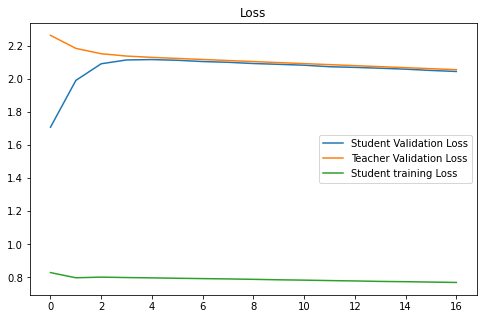

In [71]:
epochs = range(epoch+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, s_loss_array)
plt.plot(epochs, t_loss_array)
plt.plot(epochs, train_loss_array)
plt.title("Loss")
plt.legend(["Student Validation Loss", "Teacher Validation Loss","Student training Loss"])

In [73]:
len(train_loader)

562

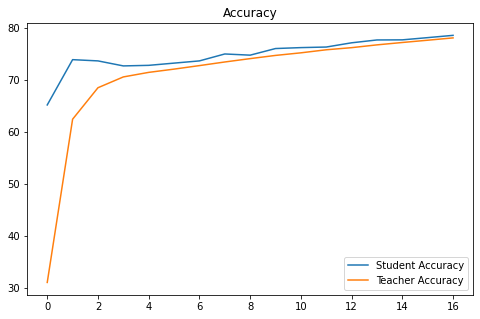

In [72]:
plt.figure(figsize=(8,5))
plt.plot(epochs, student_accuracy)
plt.plot(epochs, teacher_accuracy)
plt.title("Accuracy")
plt.legend(["Student Accuracy", "Teacher Accuracy"])

Text(0.5, 1.0, 'Consistency weight')

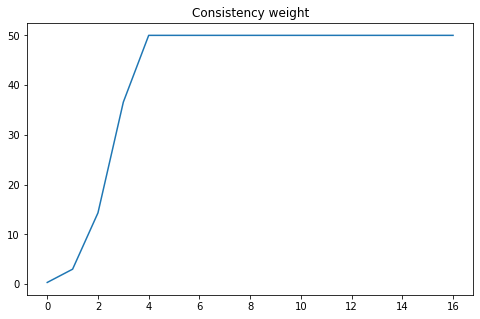

In [95]:
plt.figure(figsize=(8,5))
plt.plot(epochs, consistency_array)
plt.title("Consistency weight")

In [98]:
args.initial_lr

0.001

In [40]:
def train_normal(train_loader, model, optimizer, epoch, args):
    class_criterion = nn.CrossEntropyLoss()
    
    model.train()

    for batch, (X,y) in enumerate(train_loader):
        
        output = model(X)
        loss = class_criterion(output, y)
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        num = int(len(train_loader)/2)
        if batch % num == 0:
            print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples")

    print(f"Training Loss = {loss}")

In [41]:
from tqdm.auto import tqdm

student_accuracy = []
teacher_accuracy = []

global_step = 0
for epoch in tqdm(range(args.epochs)):
    train_normal(train_loader, model_2, optimizer_2, epoch, args)
    s_acc, s_loss = validate(eval_loader, model_2, args)
    student_accuracy.append(s_acc)
    t_acc, t_loss = validate(eval_loader, model_2, args)
    teacher_accuracy.append(t_acc)
    
    print(f"Student Accuracy = {s_acc*100}, Teacher accuracy = {t_acc*100}")

  0%|          | 0/4 [00:00<?, ?it/s]

Looked at 0/60000 samples
Looked at 30016/60000 samples
Training Loss = 0.8393805623054504


c:\Users\Parth\miniconda3\envs\tftorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 25%|██▌       | 1/4 [00:36<01:48, 36.11s/it]

Student Accuracy = 65.23686305732484, Teacher accuracy = 65.23686305732484
Looked at 0/60000 samples
Looked at 30016/60000 samples
Training Loss = 0.7108218669891357


 50%|█████     | 2/4 [01:12<01:12, 36.14s/it]

Student Accuracy = 73.218550955414, Teacher accuracy = 73.218550955414
Looked at 0/60000 samples
Looked at 30016/60000 samples
Training Loss = 0.625800609588623


 75%|███████▌  | 3/4 [01:48<00:36, 36.29s/it]

Student Accuracy = 76.26393312101911, Teacher accuracy = 76.26393312101911
Looked at 0/60000 samples
Looked at 30016/60000 samples
Training Loss = 0.5647347569465637


100%|██████████| 4/4 [02:24<00:00, 36.12s/it]

Student Accuracy = 78.6624203821656, Teacher accuracy = 78.6624203821656


In [84]:
args.exclude_unlabeled == False

False